In [1]:
from arch.ADMM_net import ADMM_net
from arch.HybridNet import *
from arch.Mosiac import Mosiac_Layer
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from load_config_noarg import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
net = ADMM_net()
ckpt = torch.load(r'nets\ADMM_net\2024_02_06_18_43_13\model\model_epoch_240.pth')
net.load_state_dict({k.replace('module.', ''): v for k, v in ckpt.items()},
                              strict=True)
net = net.to(device)

hybnet = HybridNet(fnet_path, 10,400,[121,9,500,500,121], device, QEC=QEC)

Phi_data_tensor = hybnet.show_hw_weights()
Phi_model = Mosiac_Layer((3, 3), [[0, 1, 2], [3, 4, 5], [6, 7, 8]]).cuda()
image = torch.ones(10, 128, 128, 121)
Phi = Phi_model.get_Phi(image, Phi_data_tensor)
Phi = Phi.permute(0, 3, 1, 2).cuda()
Phi = Phi.contiguous()
Phi_s = torch.sum(Phi ** 2, 1)
Phi_s[Phi_s == 0] = 1
input_mask_train_my = (Phi, Phi_s)

In [3]:
gt = sio.loadmat(r'nets\ADMM_net\2024_02_06_18_43_13\result\Test_240_46.87_0.974.mat')['truth']
gt = torch.from_numpy(gt).float().to(device)
gt = gt.permute(0, 3, 1, 2)

In [4]:
input_meas_my = torch.sum(Phi *gt, 1)
output = net(input_meas_my, input_mask_train_my)

In [8]:
MatchLossFcn(gt, output)

tensor(1.2097e-05, device='cuda:0', grad_fn=<MseLossBackward0>)

In [7]:
gt.max()

tensor(0.3162, device='cuda:0')

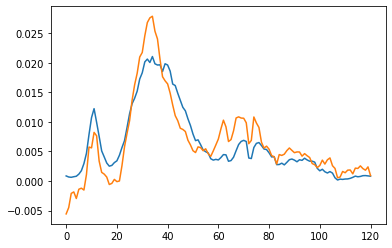

In [6]:
plt.plot(gt[0, :, 64, 64].cpu().detach().numpy())
plt.plot(output[0, :, 64, 64].cpu().detach().numpy())